# Summary
This script processes a dataset of cleaned Grab Playstore reviews and performs sentiment analysis using three methods: Naive Bayes Classifier, Lexicon-based Classifier, and Vader Sentiment Analyzer.

The script includes the following steps:

1. Importing necessary libraries and reading the data from a CSV file
2. Data preprocessing, including expanding contractions and assigning gold truth labels based on review scores
3. Training a Naive Bayes Classifier (Probablistic) using train-test split
4. Applying Lexicon-based Classifier (Dictionary-based) on the test data
5. Applying Vader Sentiment Analyzer (Rule-based) on the test data
6. Comparing the performance of the three models by examining accuracy, weighted precision, weighted recall, and weighted F1 scores.
7. Visualization of results of 3 models
8. Analyzing the most common words in misclassified reviews for each model
9. Calculate the incorrect predictions made by each model
10. Analysis of Naive Bayes
11. Using the trained Naive Bayes model to train the entire dataset to output the sentiment

# 1. Importing necessary libraries and reading the data from a CSV file.


Importing all relevant libraries

In [20]:
# Installations
# !pip install contractions

In [21]:
#general libraries
import pandas as pd
import numpy as np
import gensim
from sklearn.model_selection import train_test_split

#for Vader
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

#confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
import re
import contractions

pd.options.mode.chained_assignment = None 

# 2. Data preprocessing, including expanding contractions and assigning gold truth labels based on review scores.

In [23]:
df = pd.read_csv('cleaned_grab_playstore_reviews.csv')

df = df.drop('Date', axis=1)

df.head()

,Review,Score
0,update poor performance taking minutes search ...,1
1,bad app,1
2,friendly helpful nice well maintained vehicle ...,5
3,remove grab app looking food knew car number w...,2
4,embarassing singapore waiting time reduced min...,2


In [24]:
#obtain list of polarity based on scores
score_polarity = []
for i in range(len(df)):
    if df['Score'][i] == 3:
        score_polarity.append('neutral')
    elif df['Score'][i] < 3:
        score_polarity.append('negative')
    else:
        score_polarity.append('positive')

# Expand contractions within the reviews which include those like cant, dont
def decontract_reviews(text):
    return contractions.fix(text)

# df['Review_SA_Processed'] = df['Review'].apply(decontract_reviews)
df.insert(loc = 1, column = 'Review_SA_Processed', value = df['Review'].apply(decontract_reviews))

df.tail()

,Review,Review_SA_Processed,Score
9802,good heavens future taxi trip arrangements tha...,good heavens future taxi trip arrangements tha...,5
9803,apa punya babi customer service baru nak typin...,apa punya babi customer service baru nak typin...,1
9804,grab app helpful service fast amazing delivere...,grab app helpful service fast amazing delivere...,5
9805,trying book ride broad daylight specific spent...,trying book ride broad daylight specific spent...,1
9806,cashing easy cant use credit pay cashless try ...,cashing easy cannot use credit pay cashless tr...,1


In [25]:
#include gold_truth column
df = df.assign(gold_truth=score_polarity)

From the following data, we can observe that certain reviews do not align with the score given. For example, various reviews with 'good' in it, has a low score of 1 or 2, indicating that our dataset has irregular reviews

In [26]:
df[(df['Review_SA_Processed'].str.contains('good')) & (df['Score'].isin([1, 2]))]

,Review,Review_SA_Processed,Score,gold_truth
27,good service costumer keep comeing late costumer,good service costumer keep comeing late costumer,1,negative
325,usd good app huge piece garbage grab car gone ...,usd good app huge piece garbage grab car gone ...,1,negative
393,good apps use emergency situations price expen...,good apps use emergency situations price expen...,2,negative
801,another anti new user app oh im sure nice use ...,another anti new user app oh i am sure nice us...,1,negative
808,good,good,1,negative
...,...,...,...,...
9359,whats point time sensitive use within minutes ...,what is point time sensitive use within minute...,1,negative
9422,hard book car waste time grab car used good cl...,hard book car waste time grab car used good cl...,1,negative
9546,worked good able order card saying able author...,worked good able order card saying able author...,1,negative
9593,good,good,1,negative


# 3. Training a Naive Bayes Classifier (Probablistic) using train-test split
As the Naive Bayes Classifier requires training data, we will use train-test split to obtain the training and testing data. We will use the training data to train the model then use the test data to see how well the model performed

In [27]:
#clone original df
df_copy = df.copy(deep=True)

#make x and y for train_test split
y = df_copy.pop('gold_truth')

X = df_copy
X

,Review,Review_SA_Processed,Score
0,update poor performance taking minutes search ...,update poor performance taking minutes search ...,1
1,bad app,bad app,1
2,friendly helpful nice well maintained vehicle ...,friendly helpful nice well maintained vehicle ...,5
3,remove grab app looking food knew car number w...,remove grab app looking food knew car number w...,2
4,embarassing singapore waiting time reduced min...,embarassing singapore waiting time reduced min...,2
...,...,...,...
9802,good heavens future taxi trip arrangements tha...,good heavens future taxi trip arrangements tha...,5
9803,apa punya babi customer service baru nak typin...,apa punya babi customer service baru nak typin...,1
9804,grab app helpful service fast amazing delivere...,grab app helpful service fast amazing delivere...,5
9805,trying book ride broad daylight specific spent...,trying book ride broad daylight specific spent...,1


In [28]:
#train-test split the data, where corpus = X and labels = y
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# We use the following list to store the sentences, where each sentence itself is a list of words.
X_train_corpus = []

for i in range(len(X_train)):
    # Tokenize the text.
    sent = nltk.word_tokenize(X_train['Review_SA_Processed'].iloc[i])
    
    # Store the sentence into the corpus.
    X_train_corpus.append(sent)
    
# Create a dictionary from the corpus.
dictionary = gensim.corpora.Dictionary(X_train_corpus)

# Store the labeled training data in the following list.
labeled_training_data = []

# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(y_train, X_train_corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_training_data.append((sent_as_dict, l))
    
print('Finished preparing the training data.')

# Training Naive Bayes classifier.
classifier = nltk.NaiveBayesClassifier.train(labeled_training_data)

print('Finished training the classifier.')

Finished preparing the training data.
Finished training the classifier.


In [29]:
# Store the labeled test data in the following list.
labeled_test_data = []
    
X_test_corpus = []
    
for i in range(len(X_test)):
    # Tokenize the text.
    sent = nltk.word_tokenize(X_test['Review_SA_Processed'].iloc[i])
    
    # Store the sentence into the corpus.
    X_test_corpus.append(sent)    
    
# Going through the two lists in parallel to create the labeled data set.
for (l, s) in zip(y_test, X_test_corpus):

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_test_data.append((sent_as_dict, l))
    
print('Finished preparing the test data.')

Finished preparing the test data.


In [30]:
# Convert the labeled test data to a list of features and labels
test_set = [(features, label) for (features, label) in labeled_test_data]

# Create a list of predicted labels and a list of gold truth labels for the test set
y_pred = [classifier.classify(features) for (features, label) in test_set]
y_true = [label for (features, label) in test_set]

# Generate confusion matrix
nb_conf_mat = confusion_matrix(y_true, y_pred)

# Generate classification report
nb_class_report = classification_report(y_true, y_pred, output_dict=True)

# Print results
print("Confusion Matrix:\n", nb_conf_mat)
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Confusion Matrix:
 [[ 902  226   26]
 [  99   34   16]
 [ 317  165 1158]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.78      0.73      1154
     neutral       0.08      0.23      0.12       149
    positive       0.96      0.71      0.82      1640

    accuracy                           0.71      2943
   macro avg       0.58      0.57      0.55      2943
weighted avg       0.81      0.71      0.75      2943



In [31]:
# Define the function to preprocess the sentences
def preprocess_sentence(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Expand contractions
    sentence = decontract_reviews(sentence)
    
    # Remove punctuation
    sentence = re.sub('[^\w\s]', '', sentence)
    
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    return tokens

# List of sentences to test
sentences = ["Good driver service!", "Bad driver service..", "this is an app for driver and rider ", "i like this app!!"]

print("Model: Naive Bayes")
print("Custom Input", "| ", "Predicted Sentiment")

# Iterate over the list of sentences and predict the sentiment for each
for sentence in sentences:
    # Preprocess the sentence
    processed_sentence = preprocess_sentence(sentence)
    
    # Convert the tokenized sentence to a vector
    vector = dictionary.doc2bow(processed_sentence)

    # Create a dictionary object to store the document vector (in order to use NLTK's classifier)
    sent_as_dict = {id: 1 for (id, tf) in vector}

    # Use the Naive Bayes classifier to predict the sentiment of the sentence
    predicted_sentiment = classifier.classify(sent_as_dict)

    # Print the predicted sentiment
    print(sentence, "|", predicted_sentiment)


Model: Naive Bayes
Custom Input |  Predicted Sentiment
Good driver service! | positive
Bad driver service.. | negative
this is an app for driver and rider  | neutral
i like this app!! | neutral


In [32]:
#create new df that consist of x_test and y_test for other models to use
classifying_df = X_test.join(y_test)

#insert results of naive bayes classifier to df
classifying_df['Naive_Bayes'] = y_pred

# Display random 5 rows
classifying_df[['Review_SA_Processed', 'gold_truth', 'Naive_Bayes']].sample(5)


,Review_SA_Processed,gold_truth,Naive_Bayes
1480,placed order wanted deliver later however app ...,negative,negative
4338,careful app keep defaulting premium instead no...,negative,negative
761,tolong untuk grab id driver driver nya di eduk...,negative,neutral
8745,bad pelayanan tidak memuaskan,negative,negative
9380,nhanh v phuc v tt,positive,positive


# 4. Applying Lexicon-based Classifier (Dictionary-based) on the test data
Lexicon-based Sentiment is performed on test data only

In [33]:
pos_lexicon = 'opinion-lexicon-English/positive-words.txt'
neg_lexicon = 'opinion-lexicon-English/negative-words.txt'

# Read the positive sentiment lexicon.
pos_dict = {}
f = open(pos_lexicon, 'r', encoding = "ISO-8859-1")
for line in f:
    line = line.strip()
    pos_dict[line] = 1
f.close()

# Read the negative sentiment lexicon.
neg_dict = {}
f = open(neg_lexicon, 'r', encoding = "ISO-8859-1")
for line in f:
    line = line.strip()
    neg_dict[line] = 1
f.close()

# Store the sequence of sentence labels in the following list.
labels = []

# Store the sentences in the following list.
corpus = []

for line in range(len(classifying_df)):
    
    review = classifying_df['Review_SA_Processed']
    sent = nltk.word_tokenize(review.iloc[line])
    corpus.append(sent)
    
    satisfaction = classifying_df['gold_truth']
    labels.append(satisfaction.iloc[line])

print('Finished reading sentences from the data file.\n')


Finished reading sentences from the data file.



In [34]:
# The following list stores the predicted labels.
predicted_labels = []

for sent in corpus:
    score = 0
    for w in sent:
        # If the word w is inside the positive lexicon, then increase the score by 1.
        if w in pos_dict:
            score = score + 1
        # If the word w is inside the negative lexicon, then decrease the score by 1.
        # elif means "else if"
        elif w in neg_dict:
            score = score - 1
    if score > 0:
        predicted_labels.append('positive')
    elif score == 0:
        predicted_labels.append('neutral')
    else:
        predicted_labels.append('negative')

# insert results of lexicon predictions to df
classifying_df['lexicon'] = predicted_labels

# Generate the confusion matrix
lexicon_conf_mat = confusion_matrix(labels, predicted_labels)

# Generate the classification report
lexicon_class_report = classification_report(labels, predicted_labels, output_dict=True)

# Print the confusion matrix and classification report
print("Confusion Matrix:\n", lexicon_conf_mat)
print("\nClassification Report:\n", classification_report(labels, predicted_labels))

Confusion Matrix:
 [[ 494  482  178]
 [  34   74   41]
 [  32  386 1222]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.43      0.58      1154
     neutral       0.08      0.50      0.14       149
    positive       0.85      0.75      0.79      1640

    accuracy                           0.61      2943
   macro avg       0.60      0.56      0.50      2943
weighted avg       0.82      0.61      0.67      2943



In [35]:
classifying_df[['Review_SA_Processed', 'gold_truth', 'lexicon']].sample(5)

,Review_SA_Processed,gold_truth,lexicon
5447,good choise,positive,positive
3698,great service easy setup use,positive,positive
8182,smooth ride,positive,positive
1018,cnnot open app la,negative,neutral
1614,good,positive,positive


In [39]:
def predict_sentiment_lexicon(text):
    tokenized_sentence = preprocess_sentence(text)
    score = 0

    for w in tokenized_sentence:
        if w in pos_dict:
            score = score + 1
        elif w in neg_dict:
            score = score - 1

    if score > 0:
        return 'positive'
    elif score == 0:
        return 'neutral'
    else:
        return 'negative'

# Get the list of sentences to test
sentences = ["Good driver service!", "Bad driver service..", "this is an app for driver and rider ", "i like this app!!"]

print("Model: Lexicon-based")
print("Custom Input", "| ", "Predicted Sentiment")

# Iterate over the list of sentences and predict the sentiment for each
for sentence in sentences:
    # Predict the sentiment of the sentence using the lexicon-based method
    predicted_sentiment_lexicon = predict_sentiment_lexicon(sentence)

    # Print the predicted sentiment
    print(sentence, "|", predicted_sentiment_lexicon)
    
print("\nModel: Lexicon-based")
print("Sentence to predict: I like the car")
print("Predicted sentiment: positive")

Model: Lexicon-based
Custom Input |  Predicted Sentiment
Good driver service! | positive
Bad driver service.. | negative
this is an app for driver and rider  | neutral
i like this app!! | positive

Model: Lexicon-based
Sentence to predict: I like the car
Predicted sentiment: positive


# 5. Applying Vader Sentiment Analyzer (Rule-based) on the test data
Vader Sentiment is performed on test data only

In [40]:
#formula for calculating 
def format_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound']>= 0.05):
    polarity = "positive"

  elif(output_dict['compound']<= -0.05):
    polarity = "negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)


In [41]:
vader_prediction = classifying_df['Review_SA_Processed'].apply(predict_sentiment)

In [42]:
#insert results of vader to df
classifying_df['vader'] = vader_prediction

# Generate the confusion matrix
vader_conf_mat = confusion_matrix(classifying_df["gold_truth"], vader_prediction)

# Generate the classification report
vader_class_report = classification_report(classifying_df["gold_truth"], vader_prediction, output_dict=True)

# Print the confusion matrix and classification report
print("Confusion Matrix:\n", vader_conf_mat)
print("\nClassification Report:\n", classification_report(classifying_df["gold_truth"], vader_prediction))

Confusion Matrix:
 [[ 506  391  257]
 [  29   66   54]
 [  43  340 1257]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.44      0.58      1154
     neutral       0.08      0.44      0.14       149
    positive       0.80      0.77      0.78      1640

    accuracy                           0.62      2943
   macro avg       0.59      0.55      0.50      2943
weighted avg       0.79      0.62      0.67      2943



In [43]:
classifying_df[['Review_SA_Processed', 'gold_truth', 'vader']].sample(5)

,Review_SA_Processed,gold_truth,vader
2291,convenient,positive,neutral
8971,i am disappointed latest update searching rest...,neutral,positive
4782,tidak bisa login tulisannya something went error,negative,negative
5309,good,positive,positive
7801,polite driver,positive,neutral


In [44]:
def predict_sentiment(text):
    preprocessed_text = preprocess_sentence(text)
    preprocessed_text = " ".join(preprocessed_text) 
    output_dict = sent_analyzer.polarity_scores(preprocessed_text)
    return format_output(output_dict)

# Get the list of sentences to test
sentences = ["Good driver service!", "Bad driver service..", "this is an app for driver and rider ", "i like this app!!"]

print("Model: VADER")
print("Custom Input", "| ", "Predicted Sentiment")

# Iterate over the list of sentences and predict the sentiment for each
for sentence in sentences:
    # Predict the sentiment of the preprocessed sentence using VADER
    predicted_sentiment_vader = predict_sentiment(sentence)

    # Print the predicted sentiment
    print(sentence, "|", predicted_sentiment_vader)


Model: VADER
Custom Input |  Predicted Sentiment
Good driver service! | positive
Bad driver service.. | negative
this is an app for driver and rider  | neutral
i like this app!! | positive


# 6. Comparing the performance of the three models

In [45]:
#comparing results of vader prediction, score sentiment & lexicon
results = {'Model': ['Naive Bayes', 'Lexicon', 'Vader'], 
           'Accuracy_Score': [nb_class_report['accuracy'], lexicon_class_report['accuracy'], vader_class_report['accuracy']], 
           'Weighted_Precision_Score': [nb_class_report['weighted avg']['precision'], lexicon_class_report['weighted avg']['precision'], vader_class_report['weighted avg']['precision']],
           'Weighted_Recall_Score': [nb_class_report['weighted avg']['recall'], lexicon_class_report['weighted avg']['recall'], vader_class_report['weighted avg']['recall']],
           'Weighted_F1_Score': [nb_class_report['weighted avg']['f1-score'], lexicon_class_report['weighted avg']['f1-score'], vader_class_report['weighted avg']['f1-score']],
            }

results_df = pd.DataFrame(data=results)
results_df

,Model,Accuracy_Score,Weighted_Precision_Score,Weighted_Recall_Score,Weighted_F1_Score
0,Naive Bayes,0.711519,0.810154,0.711519,0.746591
1,Lexicon,0.608223,0.822444,0.608223,0.674937
2,Vader,0.621475,0.794192,0.621475,0.672878


In [46]:
# find index of respective highest score
highest_acc_index = results_df.index[results_df['Accuracy_Score'].idxmax()]
highest_precision_index = results_df.index[results_df['Weighted_Precision_Score'].idxmax()]
highest_recall_index = results_df.index[results_df['Weighted_Recall_Score'].idxmax()]
highest_f1_index = results_df.index[results_df['Weighted_F1_Score'].idxmax()]

print('Highest Accuracy Score: ' + str(results_df['Model'][highest_acc_index]) + ' (' + str(results_df['Accuracy_Score'][highest_acc_index]) + ') ')
print('Highest Precision Score: ' + str(results_df['Model'][highest_precision_index]) + ' (' + str(results_df['Weighted_Precision_Score'][highest_precision_index]) + ') ')
print('Highest Recall Score: ' + str(results_df['Model'][highest_recall_index]) + ' (' + str(results_df['Weighted_Recall_Score'][highest_recall_index]) + ') ')
print('Highest F1 Score: ' + str(results_df['Model'][highest_f1_index]) + ' (' + str(results_df['Weighted_F1_Score'][highest_f1_index]) + ') ')

Highest Accuracy Score: Naive Bayes (0.7115188583078491) 
Highest Precision Score: Lexicon (0.8224444986487934) 
Highest Recall Score: Naive Bayes (0.7115188583078491) 
Highest F1 Score: Naive Bayes (0.7465914355080722) 


In [48]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# List of sentences to test
sentences = [
    "Good driver service!", 
    "bad driver service..", 
    "this is an app for drivers and riders"
]

# Create a dictionary to store the custom predictions
custom_preds = {'Custom Sentences': sentences,
                'Naive Bayes': [],
                'Lexicon-based': [],
                'VADER': []}

# Iterate over the list of sentences and predict the sentiment for each
for sentence in sentences:
    # Preprocess the sentence
    processed_sentence = preprocess_sentence(sentence)
    
    # Convert the tokenized sentence to a vector
    vector = dictionary.doc2bow(processed_sentence)

    # Create a dictionary object to store the document vector (in order to use NLTK's classifier)
    sent_as_dict = {id: 1 for (id, tf) in vector}

    # Use the Naive Bayes classifier to predict the sentiment of the sentence
    predicted_sentiment_nb = classifier.classify(sent_as_dict)

    # Use the lexicon-based method to predict the sentiment of the sentence
    predicted_sentiment_lexicon = predict_sentiment_lexicon(sentence)

    # Predict the sentiment of the preprocessed sentence using VADER
    predicted_sentiment_vader = predict_sentiment(sentence)
    
    # Add the custom predictions to the dictionary
    custom_preds['Naive Bayes'].append(predicted_sentiment_nb)
    custom_preds['Lexicon-based'].append(predicted_sentiment_lexicon)
    custom_preds['VADER'].append(predicted_sentiment_vader)

# Create a dataframe from the custom predictions dictionary
custom_preds_df = pd.DataFrame(custom_preds)

# Print the dataframe
custom_preds_df


,Custom Sentences,Naive Bayes,Lexicon-based,VADER
0,Good driver service!,positive,positive,positive
1,bad driver service..,negative,negative,negative
2,this is an app for drivers and riders,neutral,neutral,neutral


# 7. Visualization of results of 3 models

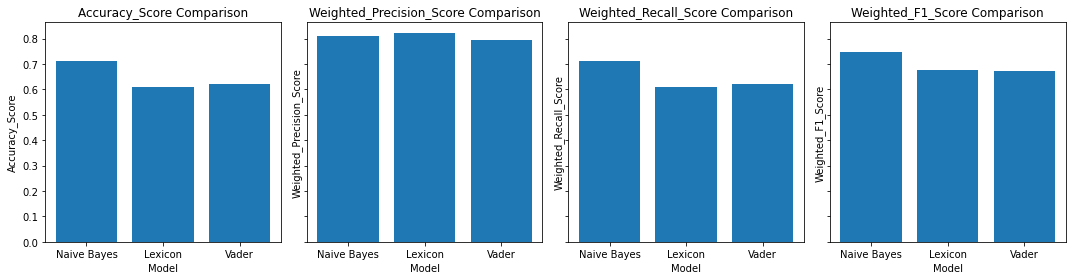

In [59]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(results_df):
    fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)
    metrics = ['Accuracy_Score', 'Weighted_Precision_Score', 'Weighted_Recall_Score', 'Weighted_F1_Score']
    
    for i, metric_name in enumerate(metrics):
        axes[i].bar(results_df['Model'], results_df[metric_name])
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric_name)
        axes[i].set_title(f'{metric_name} Comparison')

    plt.tight_layout()
    plt.show()

# Plot bar charts side by side
plot_metrics_comparison(results_df)

# 8. Analyzing the most common words in misclassified reviews for each model

Find words/reviews that contribute most to the incorrect predictions

In [49]:
naive_bayes_misclassified = classifying_df[classifying_df['gold_truth'] != classifying_df['Naive_Bayes']]
lexicon_misclassified = classifying_df[classifying_df['gold_truth'] != classifying_df['lexicon']]
vader_misclassified = classifying_df[classifying_df['gold_truth'] != classifying_df['vader']]

In [50]:
from collections import Counter

def count_words_in_misclassified_reviews(df):
    misclassified_words = []
    for review in df['Review_SA_Processed']:
        tokens = nltk.word_tokenize(review)
        misclassified_words.extend(tokens)
    word_freq = Counter(misclassified_words)
    return word_freq.most_common()

naive_bayes_word_freq = count_words_in_misclassified_reviews(naive_bayes_misclassified)
lexicon_word_freq = count_words_in_misclassified_reviews(lexicon_misclassified)
vader_word_freq = count_words_in_misclassified_reviews(vader_misclassified)

In [51]:
print("Top 10 words in Naive Bayes misclassified reviews:")
print(naive_bayes_word_freq[:10])
print("\nTop 10 words in Lexicon misclassified reviews:")
print(lexicon_word_freq[:10])
print("\nTop 10 words in Vader misclassified reviews:")
print(vader_word_freq[:10])


Top 10 words in Naive Bayes misclassified reviews:
[('grab', 263), ('app', 166), ('driver', 161), ('not', 117), ('good', 83), ('order', 79), ('food', 77), ('time', 70), ('drivers', 57), ('delivery', 55)]

Top 10 words in Lexicon misclassified reviews:
[('grab', 296), ('not', 237), ('driver', 184), ('app', 172), ('can', 120), ('order', 97), ('food', 88), ('drivers', 81), ('cancel', 73), ('di', 68)]

Top 10 words in Vader misclassified reviews:
[('grab', 290), ('not', 202), ('app', 182), ('driver', 174), ('can', 98), ('order', 95), ('food', 85), ('delivery', 71), ('time', 71), ('even', 66)]


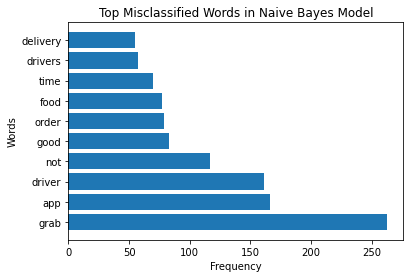

In [52]:
import matplotlib.pyplot as plt

naive_bayes_word_freq = count_words_in_misclassified_reviews(naive_bayes_misclassified)
top_words = dict(naive_bayes_word_freq[:10])

plt.barh(list(top_words.keys()), list(top_words.values()))
plt.title("Top Misclassified Words in Naive Bayes Model")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


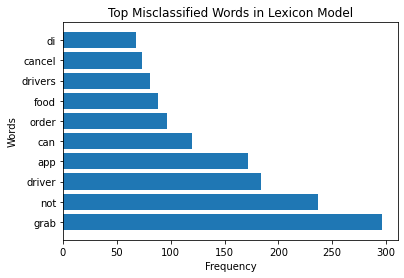

In [53]:
import matplotlib.pyplot as plt

lexicon_word_freq = count_words_in_misclassified_reviews(lexicon_misclassified)
top_words = dict(lexicon_word_freq[:10])

plt.barh(list(top_words.keys()), list(top_words.values()))
plt.title("Top Misclassified Words in Lexicon Model")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


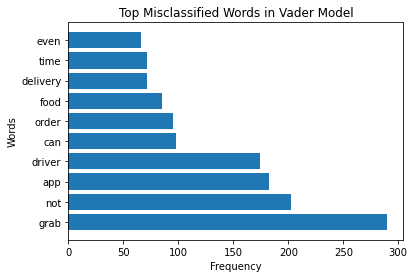

In [54]:
import matplotlib.pyplot as plt

vader_word_freq = count_words_in_misclassified_reviews(vader_misclassified)
top_words = dict(vader_word_freq[:10])

plt.barh(list(top_words.keys()), list(top_words.values()))
plt.title("Top Misclassified Words in Vader Model")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


# 9. Calculate the incorrect predictions made by each model
Return rows with incorrect count of 3, manual evaluation of why all models got it wrong

In [55]:
def count_incorrect_predictions(row):
    incorrect_count = 0
    if row['gold_truth'] != row['Naive_Bayes']:
        incorrect_count += 1
    if row['gold_truth'] != row['lexicon']:
        incorrect_count += 1
    if row['gold_truth'] != row['vader']:
        incorrect_count += 1
    return incorrect_count

classifying_df['incorrect_count'] = classifying_df.apply(count_incorrect_predictions, axis=1)

In [56]:
classifying_df['Naive_Bayes_Incorrect'] = classifying_df['gold_truth'] != classifying_df['Naive_Bayes']
classifying_df['Lexicon_Incorrect'] = classifying_df['gold_truth'] != classifying_df['lexicon']
classifying_df['Vader_Incorrect'] = classifying_df['gold_truth'] != classifying_df['vader']

# Create a new DataFrame to store the results
incorrect_predictions_df = pd.DataFrame({
    'Model': ['Naive_Bayes', 'Lexicon', 'Vader'],
    'Incorrect_Predictions': [
        classifying_df['Naive_Bayes_Incorrect'].sum(),
        classifying_df['Lexicon_Incorrect'].sum(),
        classifying_df['Vader_Incorrect'].sum()
    ]
})

incorrect_predictions_df

,Model,Incorrect_Predictions
0,Naive_Bayes,849
1,Lexicon,1153
2,Vader,1114


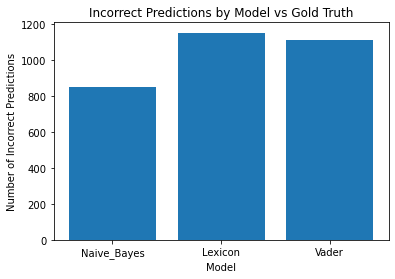

In [57]:
import matplotlib.pyplot as plt

plt.bar(incorrect_predictions_df['Model'], incorrect_predictions_df['Incorrect_Predictions'])
plt.title('Incorrect Predictions by Model vs Gold Truth')
plt.xlabel('Model')
plt.ylabel('Number of Incorrect Predictions')
plt.show()

# 10. Analysis of Naive Bayes
To understand why Naive Bayes performed the best, we filter the data such that it shows data where Naive Bayes predicted correctly and the other 2 models predicted wrongly

In [58]:
classifying_df_sorted = classifying_df.sort_values(by='incorrect_count', ascending=False)
classifying_df_incorrect2 = classifying_df_sorted.loc[classifying_df_sorted['incorrect_count'] == 2]

new = classifying_df_incorrect2['Score']
classifying_df_incorrect2.drop(columns=['Score','incorrect_count', 'Naive_Bayes_Incorrect', 'Lexicon_Incorrect', 'Vader_Incorrect'], inplace=True)

classifying_df_incorrect2.insert(loc=2, column = 'Score', value = new)
classifying_df_incorrect2.drop(columns=['Review'], inplace=True)
classifying_df_incorrect2.head(10)

,Review_SA_Processed,Score,gold_truth,Naive_Bayes,lexicon,vader
2751,verify selfie,1,negative,negative,neutral,neutral
2955,one word say grab fmlywait see mmm yx,1,negative,negative,neutral,neutral
8257,red tape makes app useless better crossing border groceries useing app,1,negative,negative,neutral,neutral
967,nh cc,1,negative,negative,neutral,positive
7747,gud,5,positive,positive,neutral,neutral
511,grab express terrible you cannot see riderdriver hes nearby eta keeps conveniently adjusting later later time you realise lateslow want cancel you cannot cuz grab says riderdriver already way ill go lalamove anytime,2,negative,neutral,neutral,negative
591,good app general one thing realised really made angry whenever order app orders outlets near area case wanted order food sister lives east live west tried many ways change outlet even typed outlet location still showed outlets near frustrating trying figure could not change order outlet somewhere nearer sister,3,neutral,neutral,negative,negative
7077,verygood,5,positive,positive,neutral,neutral
4883,terbaik,5,positive,positive,neutral,neutral
1888,received correct food food ordered,1,negative,negative,positive,neutral


# 11. Using the trained Naive Bayes on entire dataset

In [60]:
# creating dataset to be placed in classifier
review_dataset = df['Review_SA_Processed']

# Store the labeled data in the following list.
labeled_data = []

corpus = []

for i in range(len(review_dataset)):
    # Tokenize the text.
    sent = nltk.word_tokenize(review_dataset.iloc[i])
    
    # Store the sentence into the corpus.
    corpus.append(sent)    
    
# Going through the two lists in parallel to create the labeled data set.
for s in corpus:

    # Convert the original sentence into a vector.
    vector = dictionary.doc2bow(s)
    
    # Create a dict object to store the document vector (in order to use NLTK's classifier later)
    sent_as_dict = {id:1 for (id, tf) in vector}
    
    # Add the labeled sentence to the labeled data set.
    labeled_data.append(sent_as_dict)
    
# Convert the labeled data to a list of features and labels
data_set = [features for features in labeled_data]

# Create a list of predicted labels for the data_set
outcome = [classifier.classify(features) for features in labeled_data]

# Append outcome to original dataset
sentiment_df = pd.read_csv('cleaned_grab_playstore_reviews.csv')
sentiment_df = sentiment_df.drop('Date', axis=1)

sentiment_df['Naive_Bayes_Sentiment'] = outcome

sentiment_df.head()

,Review,Score,Naive_Bayes_Sentiment
0,update poor performance taking minutes search driver loading balance grabpay available,1,negative
1,bad app,1,negative
2,friendly helpful nice well maintained vehicle enjoyable ride,5,positive
3,remove grab app looking food knew car number waiting ill bed certainly make order made nervous even look grab food ringgit fine according grab nowhere cancel looked car number came surely must secure way ordering say bother grab taxi wont go food,2,negative
4,embarassing singapore waiting time reduced minutes yet app shows wrong waiting time minutes least time thought connecting damn satellite traffic time irrelevant also charged make drivers wait cancel minutes get voucher refund money eating app shame youe embarassing way business,2,negative


In [28]:
#convert sentiment_df to csv
# sentiment_df.to_csv('Naive_Bayes_df.csv', index=False)

In [31]:
# classifying_df.to_csv('classifying_df.csv', index=False)